## Preparation

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset

In [44]:
df = pd.read_csv("D:/project/depi-project/datasets/creditcard_balanced.csv")


features = ["V4", "V10", "V11", "V12", "V14", "V17"]
print(f"DataFrame shape before dropping outliers: {df.shape}")
rows_before = df.shape[0]

for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

print(f"DataFrame shape after dropping outliers: {df.shape}")
print(f"Rows Dropped: {rows_before - df.shape[0]}")
df.head()

DataFrame shape before dropping outliers: (474592, 7)
DataFrame shape after dropping outliers: (470621, 7)
Rows Dropped: 3971


,V4,V10,V11,V12,V14,V17,Class
0,1.378155,0.090794,-0.551600,-0.617801,-0.311169,0.207971,0
1,0.448154,-0.166974,1.612727,1.065235,-0.143772,-0.114805,0
2,0.379780,0.207643,0.624501,0.066084,-0.165946,1.109969,0
3,-0.863291,-0.054952,-0.226487,0.178228,-0.287924,-0.684093,0
4,0.403034,0.753074,-0.822843,0.538196,-1.119670,-0.237033,0


In [45]:
temp=df[features]

### Selecting Features and Target

In [46]:
x = df[features]
y = df["Class"]
temp=pd.concat([temp,y],axis=1)

In [47]:
sum=0
for i in y:
    if i==0:
        sum+=1
    else:
        continue
print(sum)

233325


In [48]:
# # Optionally normalize the PCA-treated features
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_scaled = scaler.fit_transform(x)

In [49]:
# Convert to numpy arrays
# x_scaled = np.array(x_scaled)
x = np.array(x)
y = np.array(y)

## ...

cGAN (conditional GAN)

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [51]:
# Define the generator model
def build_generator(noise_dim, label_dim, output_dim):
    noise_input = Input(shape=(noise_dim,))
    label_input = Input(shape=(label_dim,))
    merged_input = Concatenate()([noise_input, label_input])
    x = Dense(512)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(256)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(128)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    output = Dense(output_dim, activation="linear")(x)

    model = Model([noise_input, label_input], output)
    return model

In [52]:
# Define the discriminator model
def build_discriminator(input_dim, label_dim):
    data_input = Input(shape=(input_dim,))
    label_input = Input(shape=(label_dim,))
    merged_input = Concatenate()([data_input, label_input])

    x = Dense(512)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model([data_input, label_input], output)
    return model

In [53]:
# Set dimensions
noise_dim = 200  # Dimension of the noise vector
label_dim = 1  # Binary label (0 or 1)
output_dim = x.shape[1]  # Assuming 'x' is your data with PCA components or structured data

# Instantiate models
generator = build_generator(noise_dim, label_dim, output_dim)
discriminator = build_discriminator(output_dim, label_dim)

# Define loss function and optimizers
cross_entropy = BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(3e-3)
discriminator_optimizer = Adam(4e-3)

# Training parameters
SUBSET_SIZE = 10000  # You can adjust this
BATCH_SIZE = 64
HALF_BATCH = BATCH_SIZE // 2
EPOCHS = 300  # Number of epochs for training

# Create a random subset of the dataset (assuming x and y are numpy arrays)
idx = np.random.randint(0, x.shape[0], SUBSET_SIZE)
x_res_subset = x[idx]  
y_res_subset = y[idx]  # Direct indexing for labels # Assuming y is your labels (0 or 1)

# Build the dataset pipeline
dataset = tf.data.Dataset.from_tensor_slices((x_res_subset, y_res_subset))
dataset = dataset.shuffle(buffer_size=1024).batch(HALF_BATCH)


d:\project\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 0, Gen Loss: 0.7099, Disc Loss: 1.3762
Epoch 10, Gen Loss: 1.3615, Disc Loss: 1.0179
Epoch 20, Gen Loss: 8.6827, Disc Loss: 0.2759
Epoch 30, Gen Loss: 1.1858, Disc Loss: 0.9816
Epoch 40, Gen Loss: 1.1834, Disc Loss: 0.9352
Epoch 50, Gen Loss: 1.9756, Disc Loss: 1.0742
Epoch 60, Gen Loss: 1.2130, Disc Loss: 1.1058
Epoch 70, Gen Loss: 1.5478, Disc Loss: 1.0407
Epoch 80, Gen Loss: 2.8099, Disc Loss: 1.0603
Epoch 90, Gen Loss: 1.0651, Disc Loss: 1.1192
Epoch 100, Gen Loss: 1.1224, Disc Loss: 1.2429
Epoch 110, Gen Loss: 1.9253, Disc Loss: 1.1809
Epoch 120, Gen Loss: 1.3644, Disc Loss: 0.9727
Epoch 130, Gen Loss: 1.8278, Disc Loss: 1.0624
Epoch 140, Gen Loss: 1.6998, Disc Loss: 0.9119
Epoch 150, Gen Loss: 1.7883, Disc Loss: 0.9186
Epoch 160, Gen Loss: 1.6837, Disc Loss: 0.5078
Epoch 170, Gen Loss: 1.5527, Disc Loss: 0.9621
Epoch 180, Gen Loss: 1.9346, Disc Loss: 1.0257
Epoch 190, Gen Loss: 2.6856, Disc Loss: 0.7485
Epoch 200, Gen Loss: 1.7454, Disc Loss: 0.8128
Epoch 210, Gen Loss: 1.8

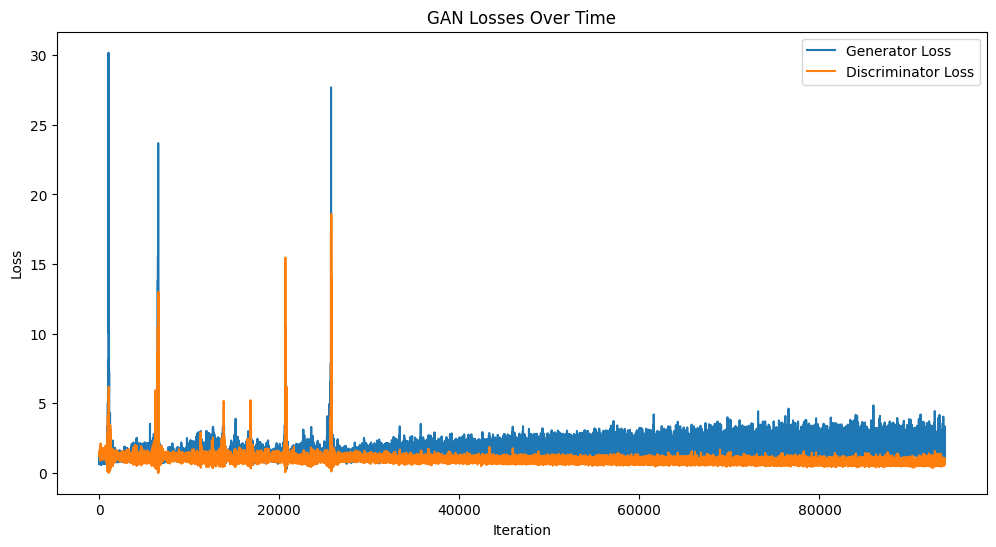

In [54]:
@tf.function
def train_step(real_data, real_labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    fake_labels = tf.random.uniform([BATCH_SIZE, 1], minval=0, maxval=2, dtype=tf.int32)
    fake_labels = tf.cast(fake_labels, tf.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator([noise, fake_labels], training=True)

        real_output = discriminator([real_data, real_labels], training=True)
        fake_output = discriminator([generated_data, fake_labels], training=True)

        # Print the first 4 outputs of the discriminator for fake data using tf.print
        # tf.print("Fake output:", fake_output[0:4])

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
gen_losses, disc_losses = [], []

for epoch in range(EPOCHS):
    for real_samples, real_labels in dataset:
        g_loss, d_loss = train_step(real_samples, real_labels)

        # Store the losses
        gen_losses.append(g_loss.numpy())
        disc_losses.append(d_loss.numpy())

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}")

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.title('GAN Losses Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf

def generate_synthetic_data_for_classes(generator, num_samples_per_class, noise_dim, label_dim, class_labels):
    synthetic_data = []
    
    for class_label in class_labels:
        print(f"Generating data for class {class_label}...")
        
        # Generate noise with the correct dimension
        noise = tf.random.normal([num_samples_per_class, noise_dim])
        
        # Create labels for the current class as a tensor
        labels = tf.constant(np.full((num_samples_per_class, label_dim), class_label, dtype=np.float32))

        # Generate synthetic data using the generator
        try:
            generated_data = generator([noise, labels], training=False)  # Pass noise and labels as separate inputs
            print(f"Successfully generated data for class {class_label}.")
        except ValueError as e:
            print(f"Error generating data for class {class_label}: {e}")
            continue
        
        # Append the generated data with corresponding class labels
        synthetic_data.append(np.column_stack((generated_data.numpy(), labels.numpy())))

    # Check if synthetic_data is empty
    if not synthetic_data:
        print("No data was generated. Please check the generator.")

    # Combine all generated data into a single DataFrame if synthetic_data is not empty
    if synthetic_data:
        synthetic_data_combined = np.vstack(synthetic_data)
        columns = [f'Feature_{i}' for i in range(synthetic_data_combined.shape[1] - 1)] + ['Class']
        df_synthetic = pd.DataFrame(synthetic_data_combined, columns=columns)
        return df_synthetic
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was generated

# Example usage
class_labels = [0, 1]  # Adjust based on your classes
num_samples_per_class = 1000  # Number of samples to generate for each class
noise_dim = 200  # Ensure this matches the input shape of the generator
label_dim = 1  # Dimension of the label input

# Assuming your generator is defined and trained
synthetic_samples_df = generate_synthetic_data_for_classes(generator, num_samples_per_class, noise_dim, label_dim, class_labels)
# Specify the file name and path
file_name = "synthetic_samples.csv"
synthetic_samples_df.columns = temp.columns
# Save the DataFrame to a CSV file
synthetic_samples_df.to_csv(file_name, index=False)
# Display the generated DataFrame if not empty
if not synthetic_samples_df.empty:
    print(synthetic_samples_df.head())
else:
    print("No synthetic samples were generated.")


Generating data for class 0...
Successfully generated data for class 0.
Generating data for class 1...
Successfully generated data for class 1.
         V4       V10       V11       V12       V14       V17  Class
0  1.101355  0.236568 -0.780997  0.032845  0.678855  0.062870    0.0
1  0.144415 -0.306610 -0.132737  0.169754  0.460051 -0.000890    0.0
2 -0.769277  1.296366 -1.366405 -1.213964  1.095386  0.686046    0.0
3 -0.397786 -0.203818  0.783985  0.614663 -0.054173 -0.736337    0.0
4  0.140990 -0.027486 -0.619310  0.340444  0.071187 -0.127888    0.0
